In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error , r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [3]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train_df.shape

(1460, 81)

In [5]:
train_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [6]:
train_df.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


# removing Outliers

In [7]:
def remove_outlier(data):
    
   
    Q1 = data.iloc[(len(data)*25//100)-1]
    Q3 = data.iloc[(len(data)*75//100)-1]
    
    print(f"Q1 is {Q1} Q3 is {Q3}")
    
    IQR = Q3-Q1
    
    print(f"IQR is {IQR}")
    
    lf = Q1-1.5*IQR
    uf = Q3+1.5*IQR
    
    print(f"Lower fence is {lf} and Upper fence is {uf}")
    
    return (data[(data>=lf) & (data<=uf)])

# Checking data types

In [8]:
train_df.dtypes[train_df.dtypes!= 'object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [9]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending = False)).head(25)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [10]:
train_df['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [11]:
train_df['MasVnrType'].fillna('no',inplace = True)
test_df['MasVnrType'].fillna('no',inplace = True)


/tmp/ipykernel_17/449166256.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrType'].fillna('no',inplace = True)
/tmp/ipykernel_17/449166256.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

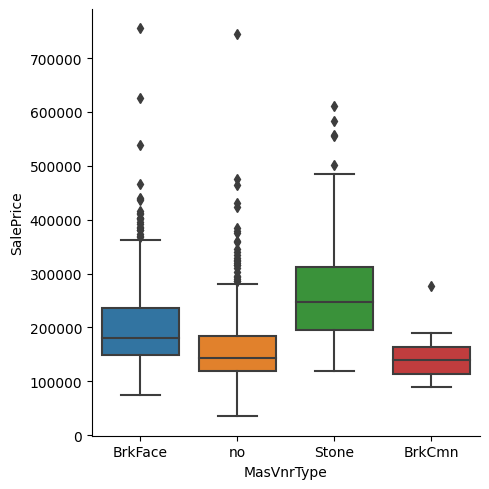

In [12]:
sns.catplot(data = train_df,x ='MasVnrType',y = 'SalePrice',kind = 'box')

/tmp/ipykernel_17/3270217170.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageType'].fillna('no',inplace = True)
/tmp/ipykernel_17/3270217170.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

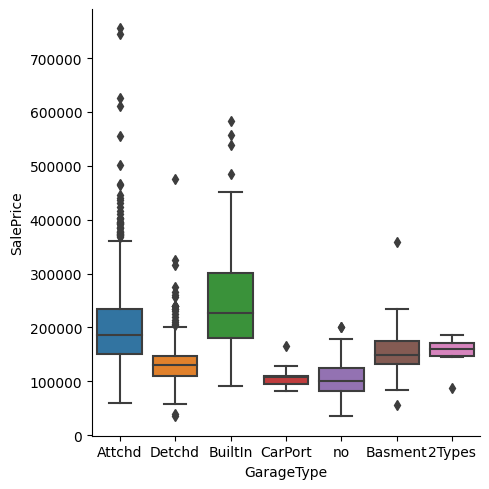

In [13]:
train_df['GarageType'].fillna('no',inplace = True)
test_df['GarageType'].fillna('no',inplace = True)
sns.catplot(data = train_df,x ='GarageType',y = 'SalePrice',kind = 'box')

/tmp/ipykernel_17/2988872783.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['FireplaceQu'].fillna('no',inplace = True)
/tmp/ipykernel_17/2988872783.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

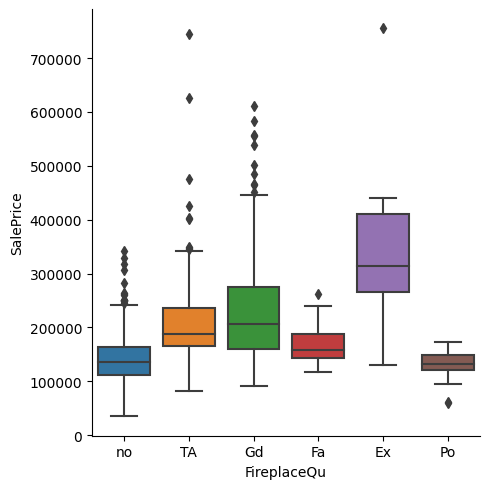

In [14]:
train_df['FireplaceQu'].fillna('no',inplace = True)
test_df['FireplaceQu'].fillna('no',inplace = True)
sns.catplot(data = train_df,x ='FireplaceQu',y = 'SalePrice',kind = 'box')

/tmp/ipykernel_17/3860814808.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageFinish'].fillna('no',inplace = True)
/tmp/ipykernel_17/3860814808.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

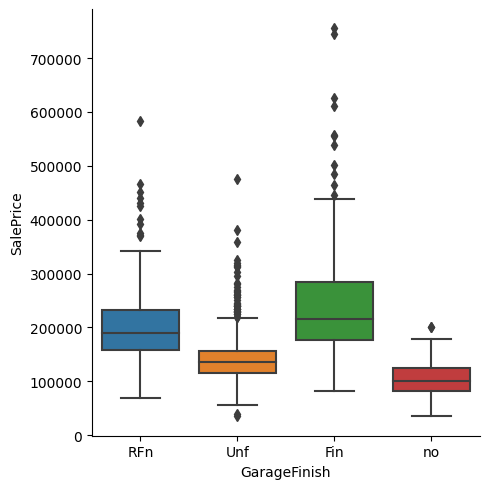

In [15]:
train_df['GarageFinish'].fillna('no',inplace = True)
test_df['GarageFinish'].fillna('no',inplace = True)
sns.catplot(data = train_df,x ='GarageFinish',y = 'SalePrice',kind = 'box')

# Droping unwanted columns

In [16]:
train_df = train_df.drop(columns = ['PoolQC','MiscFeature','Alley','Fence','GarageYrBlt','GarageCond','BsmtFinType2'])
test_df = test_df.drop(columns = ['PoolQC','MiscFeature','Alley','Fence','GarageYrBlt','GarageCond','BsmtFinType2'])

# Feature engineering

In [17]:
train_df['houseage']=train_df['YrSold']-train_df['YearBuilt']
test_df['houseage']=test_df['YrSold']-test_df['YearBuilt']

In [18]:
train_df['houseremodelage'] = train_df['YrSold']-train_df['YearRemodAdd']
test_df['houseremodelage'] = test_df['YrSold']-test_df['YearRemodAdd']

In [19]:
train_df['totalsf'] = train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['BsmtFinSF1']+train_df['BsmtFinSF2']
test_df['totalsf'] = test_df['1stFlrSF']+test_df['2ndFlrSF']+test_df['BsmtFinSF1']+test_df['BsmtFinSF2']

In [20]:
train_df['totalarea']= train_df['GrLivArea']+train_df['TotalBsmtSF']
test_df['totalarea']= test_df['GrLivArea']+test_df['TotalBsmtSF']

In [21]:
train_df = train_df.drop(columns = ['Id','YrSold','YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2','2ndFlrSF','1stFlrSF','GrLivArea','TotalBsmtSF'])
test_df = test_df.drop(columns = ['YrSold','YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2','2ndFlrSF','1stFlrSF','GrLivArea','TotalBsmtSF'])

# Correlation

<Axes: >

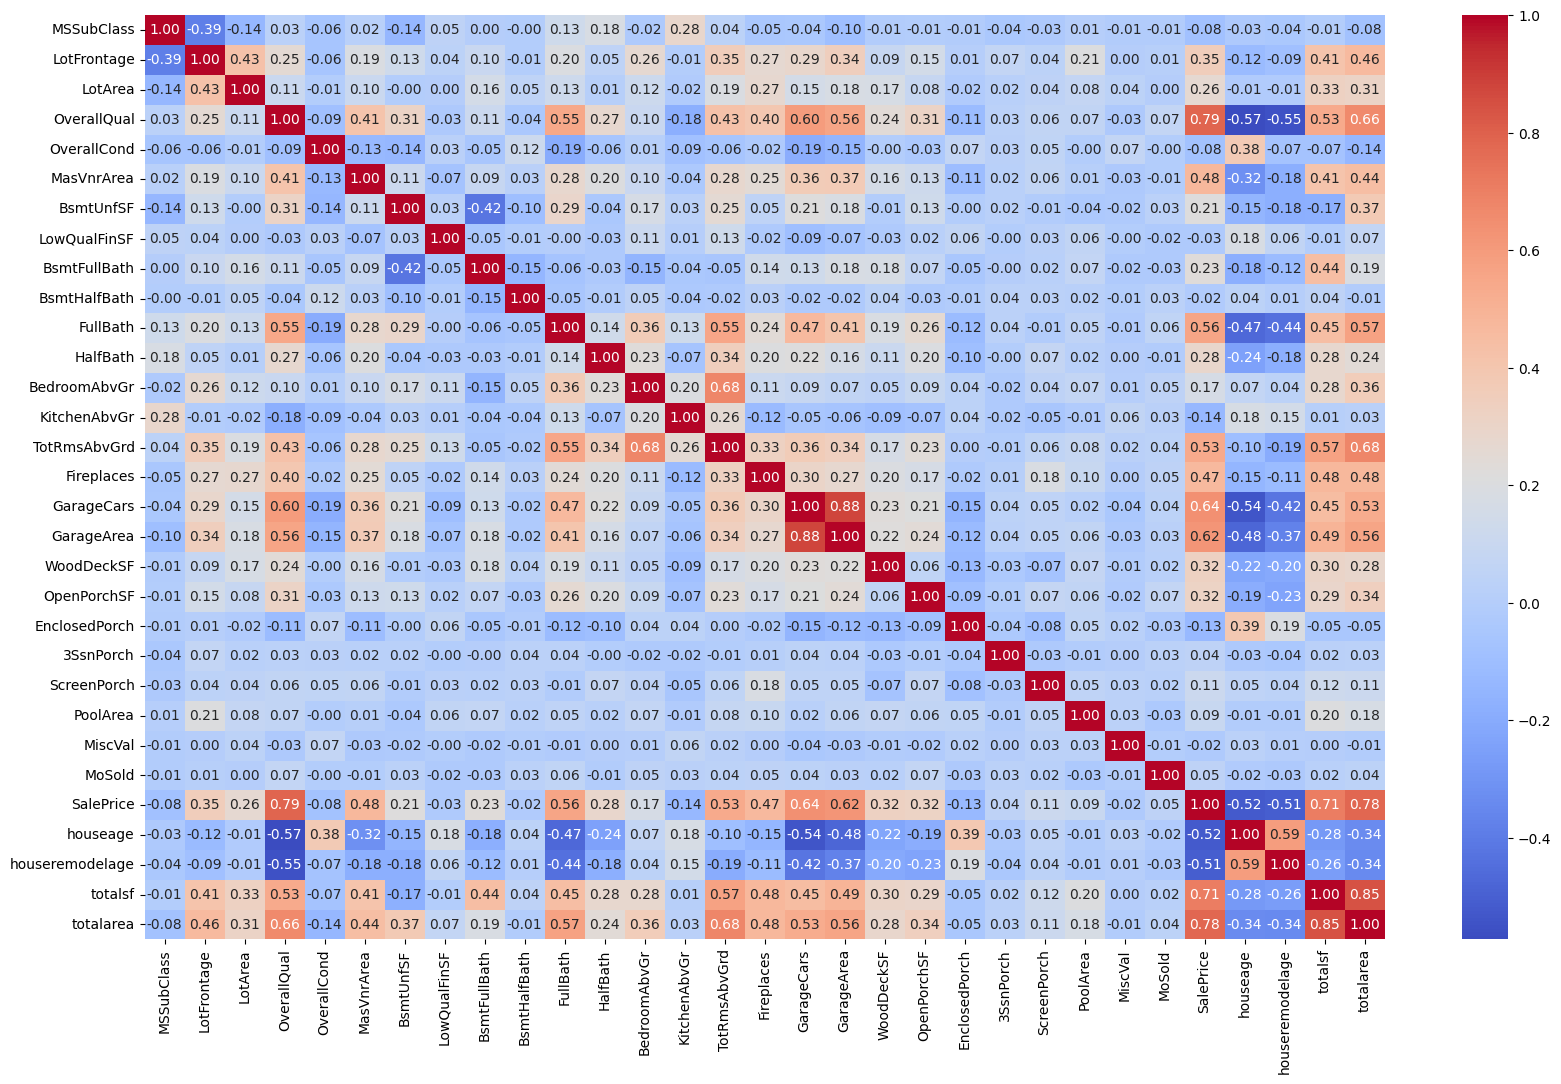

In [22]:
correlation_matrix = train_df.corr(numeric_only = True)
plt.figure(figsize = (20,12))
sns.heatmap(correlation_matrix,annot = True,cmap = 'coolwarm',fmt = '.2f')

# Droping uncorrelated columns

In [23]:
train_df = train_df.drop(columns = ['GarageArea'])
test_df = test_df.drop(columns = ['GarageArea'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

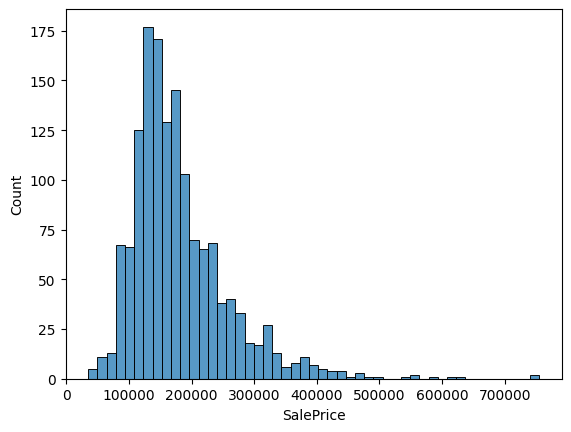

In [24]:
sns.histplot(
    train_df,
    x = train_df['SalePrice'])

In [25]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

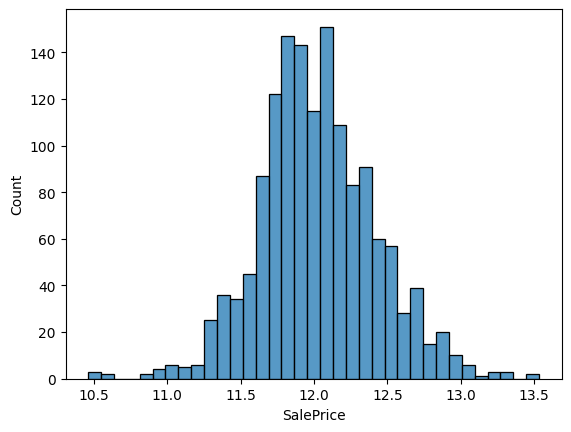

In [26]:
sns.histplot(
    train_df,
    x = train_df['SalePrice'])

# Separating numerical and categorical columns

In [27]:
train_df.dtypes[train_df.dtypes == 'object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [28]:
train_df.dtypes[train_df.dtypes != 'object']

MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
LowQualFinSF         int64
BsmtFullBath         int64
BsmtHalfBath         int64
FullBath             int64
HalfBath             int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
WoodDeckSF           int64
OpenPorchSF          int64
EnclosedPorch        int64
3SsnPorch            int64
ScreenPorch          int64
PoolArea             int64
MiscVal              int64
MoSold               int64
SalePrice          float64
houseage             int64
houseremodelage      int64
totalsf              int64
totalarea            int64
dtype: object

In [29]:
ode_col = ['LotShape','LandContour','Utilities','LandSlope','BsmtQual','BsmtFinType1','CentralAir','Functional','FireplaceQu',
          'GarageFinish','GarageQual','PavedDrive','ExterCond','KitchenQual','BsmtExposure','HeatingQC','ExterQual','BsmtCond']

In [30]:
ohe_col = ['Street','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','Exterior2nd','Exterior1st',
           'MasVnrType','Foundation','SaleType','SaleCondition','Electrical','MSZoning','Heating','RoofMatl','GarageType']

In [31]:
num_column = train_df.select_dtypes(include = ['int64','float64']).columns
num_column=num_column.drop('SalePrice')

# Making Pipeline

In [32]:
num_pipline = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

In [33]:
ode_pipline = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('Ode',OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = -1))])

In [34]:
ohe_pipline = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('Ohe',OneHotEncoder(handle_unknown = 'ignore',sparse_output = False))])

In [35]:
Col_trans = ColumnTransformer(transformers=[
    ('num_p',num_pipline,num_column),
    ('ode_p',ode_pipline,ode_col),
    ('ohe_p',ohe_pipline,ohe_col)],
                              remainder = 'passthrough')

In [36]:
pipeline = Pipeline(steps = [
    ('preprocessing',Col_trans)])

In [37]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_p',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBat...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Street', 'LotConfig',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'Exterior2nd', 'Exterior1st',
                                                   'MasVnrType', 'Foundation',
                                                   'SaleType', 'SaleCondition',
                                                   'Electrical', 'MSZoning',
                                                   'Heating', 'RoofMatl',
                                                   'GarageType'])]))])

# Separating X and Y

In [38]:
X = train_df.drop(columns = ['SalePrice'])
y= train_df['SalePrice']

In [39]:
X_preprocessed = pipeline.fit_transform(X)

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X_preprocessed,y,test_size =0.2,random_state =23)

In [41]:
lr = LinearRegression()

In [42]:
lr.fit(X_train,y_train)

LinearRegression()

In [43]:
lr_pred = lr.predict(X_test)

In [44]:
r2_score(y_test,lr_pred)

-8.377431113424339e+17

In [45]:
mean_squared_error(y_test,lr_pred)

1.293257278772972e+17

In [46]:
rfr = RandomForestRegressor(random_state =23)

In [47]:
param_grid_rfr= {
    'max_depth':[3,4,5,None],
    'n_estimators':[100,200,500],
    'min_samples_split':[3,4,5]
}

In [48]:
rfr_cv = GridSearchCV(rfr,param_grid_rfr,cv =5,scoring = 'neg_mean_squared_error',n_jobs = -1)

In [49]:
rfr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=23), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, None],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error')

In [50]:
np.sqrt(-1*rfr_cv.best_score_)

0.1420370560848694

In [51]:
rfr_cv.best_params_

{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}

In [52]:
xgbr =XGBRegressor(random_state =23)

In [53]:
param_grid_xgbr = {
    'learning_rate':[0.1,0.05],
    'max_depth':[3,4],
    'gamma':[0,0.1,0.2]}

In [54]:
xgbr_cv = GridSearchCV(xgbr,param_grid_xgbr,cv =5,scoring = 'neg_mean_squared_error',n_jobs = -1)

In [55]:
xgbr_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=23, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2], 'learning_rate': [0.1, 0.05],
                         'max_depth': [3, 4]},
             scoring='neg_mean_squared_error')

In [56]:
np.sqrt(-1*xgbr_cv.best_score_)

0.1351076572237993

In [57]:
xgbr_cv.best_params_

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3}

In [58]:
ridge = Ridge()

In [59]:
param_grid_ridge = {
    'alpha':[0.1,0.03,4,6],
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

In [60]:
ridge_cv = GridSearchCV(ridge,param_grid_ridge,cv =5,scoring = 'neg_mean_squared_error',n_jobs = -1)

In [61]:
ridge_cv.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.03, 4, 6],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             scoring='neg_mean_squared_error')

In [62]:
ridge_cv.best_params_

{'alpha': 6, 'solver': 'lsqr'}

In [63]:
np.sqrt(-1*ridge_cv.best_score_)

0.1521881346306178

In [64]:
gbr = GradientBoostingRegressor()

In [65]:
param_grid_gbr = {
    'learning_rate':[0.1,0.05,0.02],
    'max_depth':[3,4],
    'n_estimators':[100,200],
    'min_samples_split':[3,4]}

In [66]:
gbr_cv = GridSearchCV(gbr,param_grid_gbr,cv =5,scoring = 'neg_mean_squared_error',n_jobs = -1)

In [67]:
gbr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.02],
                         'max_depth': [3, 4], 'min_samples_split': [3, 4],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [68]:
gbr_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 200}

In [69]:
np.sqrt(-1*gbr_cv.best_score_)

0.13096628562836982

In [70]:
lgbm = lgb.LGBMRegressor()

In [71]:
param_grid_lgbm = {
    'boosting_type':['gbdt','dart'],
     'learning_rate':[0.1,0.05,0.02]}

In [72]:
lgbm_cv = GridSearchCV(lgbm,param_grid_lgbm,cv =5,scoring = 'neg_mean_squared_error',n_jobs = -1)

In [73]:
lgbm_cv.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 121
[LightGBM] [Info] Start training from score 12.029544


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.1, 0.05, 0.02]},
             scoring='neg_mean_squared_error')

In [74]:
lgbm_cv.best_params_

{'boosting_type': 'gbdt', 'learning_rate': 0.1}

In [75]:
np.sqrt(-1*lgbm_cv.best_score_)

0.1348517699125354

In [76]:
vr = VotingRegressor([('lgbm',lgbm_cv.best_estimator_),
                      ('gbr',gbr_cv.best_estimator_),
                      ('ridge',ridge_cv.best_estimator_),
                      ],
                     weights = [2,3,4])

In [77]:
vr.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 121
[LightGBM] [Info] Start training from score 12.029544


VotingRegressor(estimators=[('lgbm', LGBMRegressor()),
                            ('gbr',
                             GradientBoostingRegressor(min_samples_split=3,
                                                       n_estimators=200)),
                            ('ridge', Ridge(alpha=6, solver='lsqr'))],
                weights=[2, 3, 4])

In [78]:
y_pred_vr = vr.predict(X_test)

In [79]:
mean_squared_error(y_pred_vr,y_test,squared=False)

0.11860386729154324

In [80]:
estimators = [
    ('rfr',rfr_cv.best_estimator_),
    ('xgbr',xgbr_cv.best_estimator_),
    ('ridge',ridge_cv.best_estimator_),
    ('gbr',gbr_cv.best_estimator_),
    ('lgbm',lgbm_cv.best_estimator_)]

In [81]:
StackingReg =StackingRegressor(
    estimators = estimators,
    final_estimator =vr)

In [82]:
StackingReg.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 121
[LightGBM] [Info] Start training from score 12.029544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 117
[LightGBM] [Info] Start training from score 12.014335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train se

StackingRegressor(estimators=[('rfr',
                               RandomForestRegressor(min_samples_split=3,
                                                     random_state=23)),
                              ('xgbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=N...
                                            random_state=23, ...)),
                              ('ridge', Ridge(alpha=6, solver='lsqr')),
                              ('gbr',
                               GradientBoostingRegressor(min_samples_split=3,
                                                         n_estimators=200)),
                              ('lgbm', LGBMRegressor())],
                  final_estimator=VotingRegressor(estimators=[('lgbm',
                                                               LGBMRegressor()),
                                                              ('gbr',
                                                               GradientBoostingRegressor(min_samples_split=3,
                                                                                         n_estimators=200)),
                                                              ('ridge',
                                                               Ridge(alpha=6,
                                                                     solver='lsqr'))],
                                                  weights=[2, 3, 4]))

In [83]:
y_pred_stack = StackingReg.predict(X_test)

In [84]:
mean_squared_error(y_test,y_pred_stack,squared = False)

0.12167225330244334

In [85]:
df_test_preprocess = pipeline.transform(test_df)

In [86]:
y_stack = np.exp(vr.predict(df_test_preprocess))
y_stack_out =test_df[['Id']]
y_stack_out['SalePrice'] = y_stack
y_stack_out.to_csv('submission.csv',index = False)

/tmp/ipykernel_17/4000354109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_stack_out['SalePrice'] = y_stack
